# Generate Dalle Images With Conversable Agents

This notebook illustrates how to add the image generation capability to a conversable agent. 

````{=mdx}
:::info Requirements
Some extra dependencies are needed for this notebook, which can be installed via pip:

```bash
pip install pyautogen[lmm]
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````
First, let's import all the required modules to run this example.

In [1]:
import os
import re
from typing import Dict, Optional

from IPython.display import display
from PIL.Image import Image

import autogen
from autogen.agentchat.contrib import img_utils
from autogen.agentchat.contrib.capabilities import generate_images
from autogen.cache import Cache
from autogen.oai import openai_utils

/home/weitian/anaconda3/envs/autogen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's define our LLM configs.

In [2]:
gpt_config = {
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4"]}),
    "timeout": 120,
    "temperature": 0.7,
}
gpt_vision_config = {
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4-turbo-vision"]}),
    "timeout": 120,
    "temperature": 0.7,
    "max_tokens": 400,  # Needed by Azure OpenAI deployment
}
dalle_config = {
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["dall-e-3"]}),
    "timeout": 120,
    "temperature": 0.7,
}

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

Our system will consist of 2 main agents:
1. Image generator agent.
2. Critic agent.

The image generator agent will carry a conversation with the critic, and generate images based on the critic's requests.

In [3]:
CRITIC_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create an image that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

If you have no critique or a prompt, just say TERMINATE
"""

In [4]:
def _is_termination_message(msg) -> bool:
    # Detects if we should terminate the conversation
    if isinstance(msg.get("content"), str):
        return msg["content"].rstrip().endswith("TERMINATE")
    elif isinstance(msg.get("content"), list):
        for content in msg["content"]:
            if isinstance(content, dict) and "text" in content:
                return content["text"].rstrip().endswith("TERMINATE")
    return False


def critic_agent() -> autogen.ConversableAgent:
    return autogen.ConversableAgent(
        name="critic",
        llm_config=gpt_vision_config,
        system_message=CRITIC_SYSTEM_MESSAGE,
        max_consecutive_auto_reply=3,
        human_input_mode="NEVER",
        is_termination_msg=lambda msg: _is_termination_message(msg),
    )


def image_generator_agent() -> autogen.ConversableAgent:
    # Create the agent
    agent = autogen.ConversableAgent(
        name="dalle",
        llm_config=gpt_vision_config,
        max_consecutive_auto_reply=3,
        human_input_mode="NEVER",
        is_termination_msg=lambda msg: _is_termination_message(msg),
    )

    # Add image generation ability to the agent
    dalle_gen = generate_images.DalleImageGenerator(llm_config=dalle_config)
    image_gen_capability = generate_images.ImageGeneration(
        image_generator=dalle_gen, text_analyzer_llm_config=gpt_config
    )

    image_gen_capability.add_to_agent(agent)
    return agent

We'll define `extract_img` to help us extract the image generated by the image generator agent.

In [5]:
def extract_images(sender: autogen.ConversableAgent, recipient: autogen.ConversableAgent) -> Image:
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", [])
        for content in contents:
            if isinstance(content, str):
                continue
            if content.get("type", "") == "image_url":
                img_data = content["image_url"]["url"]
                images.append(img_utils.get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

Start the converstion

In [6]:
dalle = image_generator_agent()
critic = critic_agent()

img_prompt = "A happy dog wearing a shirt saying 'I Love AutoGen'. Make sure the text is clear."
# img_prompt = "Ask me how I'm doing"

result = dalle.initiate_chat(critic, message=img_prompt)

dalle (to critic):

A happy dog wearing a shirt saying 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------
critic (to dalle):

CRITICS: the image needs to improve the contrast and size of the text to enhance its clarity, and the shirt's color should not clash with the dog's fur color to maintain a harmonious color scheme.

PROMPT: here is the updated prompt!
Create an image of a joyful dog with a coat of a contrasting color to its fur, wearing a shirt with bold, large text saying 'I Love AutoGen' for clear readability.

--------------------------------------------------------------------------------
dalle (to critic):

I generated an image with the prompt: Joyful dog, contrasting coat color to its fur, shirt with bold, large text "I Love AutoGen" for clear readability.<image>

--------------------------------------------------------------------------------
critic (to dalle):

CRITICS: the image effectively sho

Let's display all the images that was generated by Dalle

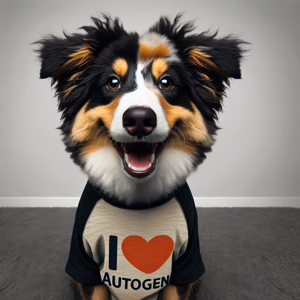

In [7]:
images = extract_images(dalle, critic)

for image in reversed(images):
    display(image.resize((300, 300)))

## Use HuggingFace text-to-image model

Let's first define our HuggingFace text-to-image model configs.

In [6]:
hf_config = {
    "config_list": autogen.config_list_from_json(
        "OAI_CONFIG_LIST", filter_dict={"api_type": ["huggingface"], "tags": ["text-to-image"]}
    ),
}

The `config_list` in `hf_config` should be something like:

```python
[
    {
        "model": "<HF_MODEL_ID_OR_URL>",
        "api_key": "<HF_API_KEY>",
        "api_type": "huggingface",
        "inference_mode": "auto" # "local", "remote", or "auto"
    }
]
```

In this sample, we will use the [stabilityai/sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) model which is a fast generative text-to-image model that can synthesize photorealistic images from a text prompt.

Now, define an image generator agent with the HuggingFace text-to-image model as backbone.

In [7]:
def hf_image_generator_agent() -> autogen.ConversableAgent:
    # Create the agent
    agent = autogen.ConversableAgent(
        name="huggingface",
        llm_config=gpt_vision_config,
        max_consecutive_auto_reply=3,
        human_input_mode="NEVER",
        is_termination_msg=lambda msg: _is_termination_message(msg),
    )

    # Add image generation ability to the agent
    huggingface_gen = generate_images.HuggingFaceImageGenerator(llm_config=hf_config)
    image_gen_capability = generate_images.ImageGeneration(
        image_generator=huggingface_gen, text_analyzer_llm_config=gpt_config
    )

    image_gen_capability.add_to_agent(agent)
    return agent

Start the conversation

In [8]:
huggingface = hf_image_generator_agent()
critic = critic_agent()

img_prompt = "A happy dog wearing a shirt saying 'I Love AutoGen'. Make sure the text is clear."

result = huggingface.initiate_chat(critic, message=img_prompt)

huggingface (to critic):

A happy dog wearing a shirt saying 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------
critic (to huggingface):

CRITICS: the image needs to improve the clarity of the text on the shirt and ensure the overall image is vibrant and engaging.

PROMPT: here is the updated prompt!
"Create a vibrant image of a joyful dog wearing a bright, eye-catching shirt. The shirt should be in a contrasting color to the dog's fur to stand out clearly. On the shirt, include the text 'I Love AutoGen' in bold, legible font, ensuring it's easily readable. The dog should be depicted in a playful pose to emphasize its happiness."

--------------------------------------------------------------------------------
huggingface (to critic):

I generated an image with the prompt: Vibrant image, joyful dog, bright, eye-catching shirt in contrasting color to dog's fur, bold, legible text 'I Love AutoGen' on shirt, pla

huggingface (to critic):

I generated an image with the prompt: Vibrant image, joyful dog, bright eye-catching shirt in contrasting color to dog's fur, text "I Love AutoGen" fully visible and centered on shirt in bold, legible font, playful pose of dog, happiness emphasized, no text obscured.<image>

--------------------------------------------------------------------------------
critic (to huggingface):

CRITICS: the image needs to improve the alignment and formatting of the text on the shirt. The words "I" and "LOVE" are separated from "AUTOGEN," which might make the message less immediately clear.

PROMPT: here is the updated prompt!
"Create a vibrant image of a joyful dog wearing a bright, eye-catching shirt in a contrasting color to the dog's fur. Ensure the entire phrase 'I Love AutoGen' is on one line, centered, and in bold, legible font on the shirt. The dog should be depicted in a playful pose, emphasizing its happiness, with the text fully visible and unobscured by any part o

Let's display all the images that was generated by HuggingFace

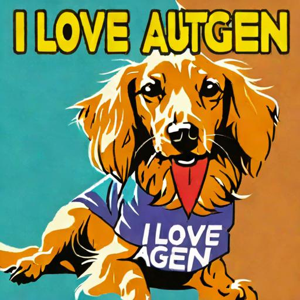

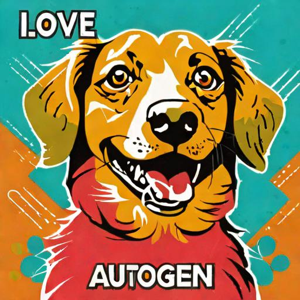

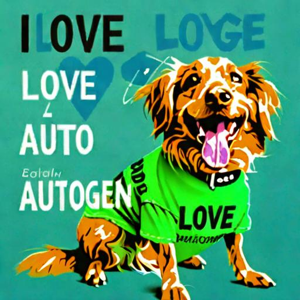

In [9]:
images = extract_images(huggingface, critic)

for image in reversed(images):
    display(image.resize((300, 300)))